## Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [1]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-pyfhu_gm


# Laboratoire 4: Régularisation

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import poutyne as pt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from deeplib.datasets import load_cifar10, load_mnist, train_valid_loaders
from deeplib.net import CifarNet, CifarNetBatchNorm
from deeplib.training import train, test

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

Files already downloaded and verified
Files already downloaded and verified


## Partie 1: Régularisation L1 et L2

### Implémentation manuelle
Dans la communauté de l'apprentissage profond, la régularisation L2 est communément appelée **weight decay**. Dans PyTorch, les optimiseurs de `torch.optim` ont un paramètre `weight_decay` pour utiliser cette régularisation. Par contre, on peut facilement implémenter manuellement la régularisation L2 comme une pénalité sur la norme des poids (voir le [chapitre 7.1](http://www.deeplearningbook.org/contents/regularization.html)).

#### Exercice
 - Complétez la fonction *loss_init* en ajoutant manuellement la pénalité sur les paramètres du réseau selon une régularisation L1 ou L2. Le paramètre *reg_alpha* correspond à l'hyperparamètre de régularisation $\alpha$ du livre ($\lambda$ dans les acétates du cours). Le paramètre *p* correspond à l'ordre de la norme: $p=1$ pour la norme L1 et $p=2$ pour la norme L2.

In [3]:
def loss_init(parameters=[], reg_alpha=0, p=2):
    cross_entropy = nn.CrossEntropyLoss()
    
    def loss_function(output, targets):
        loss = cross_entropy(output,targets)

        for param in parameters:
            # TODO
            # Solution version 1
            loss += reg_alpha/p * torch.norm(param, p=p) ** p
            
            '''
            # Solution version 2
            # Norme L1
            if p == 1:
                loss += reg_alpha * torch.abs(param).sum()
            
            # Norme L2
            elif p == 2:
                loss += reg_alpha * 1/2 * torch.pow(param, 2).sum()
            '''
        
        return loss
    return loss_function

Testez votre implémentation de la régularisation par la norme L2 ($p=2$):

In [4]:
torch.manual_seed(42)
net = CifarNet()

optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(list(net.parameters()), reg_alpha=1e-3, p=2)

history = train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Epoch: 1/5 Step: 625/625 100.00% |████████████████████|10.39s loss: 1.993497 acc: 29.165000 val_loss: 1.741876 val_acc: 39.360000
Epoch: 2/5 Step: 625/625 100.00% |████████████████████|10.71s loss: 1.511888 acc: 47.940000 val_loss: 1.407483 val_acc: 52.260000
Epoch: 3/5 Step: 625/625 100.00% |████████████████████|10.70s loss: 1.320877 acc: 55.750000 val_loss: 1.280439 val_acc: 57.400000
Epoch: 4/5 Step: 625/625 100.00% |████████████████████|10.41s loss: 1.181327 acc: 61.510000 val_loss: 1.176106 val_acc: 62.190000
Epoch: 5/5 Step: 625/625 100.00% |████████████████████|10.46s loss: 1.081472 acc: 65.750000 val_loss: 1.108733 val_acc: 65.440000


Testez votre implémentation de la régularisation par la norme L1 ($p=1$):

In [5]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(list(net.parameters()), reg_alpha=1e-3, p=1)

history = train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Epoch: 1/5 Step: 625/625 100.00% |████████████████████|10.30s loss: 2.772987 acc: 20.937500 val_loss: 2.139626 val_acc: 27.430000
Epoch: 2/5 Step: 625/625 100.00% |████████████████████|10.08s loss: 2.085810 acc: 27.622500 val_loss: 2.011732 val_acc: 30.790000
Epoch: 3/5 Step: 625/625 100.00% |████████████████████|10.05s loss: 2.020302 acc: 30.202500 val_loss: 1.955402 val_acc: 31.720000
Epoch: 4/5 Step: 625/625 100.00% |████████████████████|10.07s loss: 1.895790 acc: 35.792500 val_loss: 1.956362 val_acc: 35.070000
Epoch: 5/5 Step: 625/625 100.00% |████████████████████|10.24s loss: 1.830321 acc: 38.385000 val_loss: 1.767891 val_acc: 40.750000


### Utilisation du *weight decay*

Explorons maintenant l'utilisation du paramètre `weight_decay` disponible dans les optimiseurs de `PyTorch` pour effectuer de la régularisation L2. Nous allons entrainer un réseau de neurones avec régularisation L2 et un autre sans pour pouvoir observer l'impact de la régularisation sur l'apprentissage et le réseau appris.

In [6]:
# Paramètres
batch_size = 64
lr = 0.1
n_epoch = 15

Réseau sans régularisation L2:

Epoch:  1/15 Step: 625/625 100.00% |████████████████████|8.12s loss: 1.956466 acc: 29.155000 val_loss: 1.557106 val_acc: 44.520000
Epoch:  2/15 Step: 625/625 100.00% |████████████████████|8.18s loss: 1.436532 acc: 48.517500 val_loss: 1.294240 val_acc: 54.470000
Epoch:  3/15 Step: 625/625 100.00% |████████████████████|7.62s loss: 1.223979 acc: 56.792500 val_loss: 1.197733 val_acc: 57.630000
Epoch:  4/15 Step: 625/625 100.00% |████████████████████|7.98s loss: 1.057215 acc: 62.877500 val_loss: 1.066041 val_acc: 62.560000
Epoch:  5/15 Step: 625/625 100.00% |████████████████████|7.70s loss: 0.931777 acc: 67.505000 val_loss: 0.979787 val_acc: 66.240000
Epoch:  6/15 Step: 625/625 100.00% |████████████████████|7.87s loss: 0.824019 acc: 71.417500 val_loss: 1.001967 val_acc: 65.350000
Epoch:  7/15 Step: 625/625 100.00% |████████████████████|7.46s loss: 0.730947 acc: 74.650000 val_loss: 0.915697 val_acc: 68.460000
Epoch:  8/15 Step: 625/625 100.00% |████████████████████|7.60s loss: 0.652487 acc: 

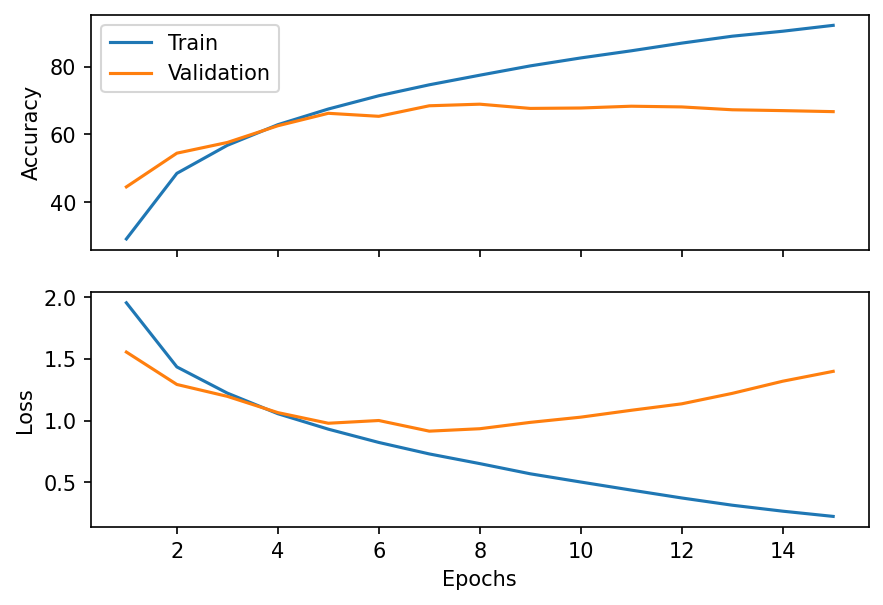

Précision en test: 66.74


In [7]:
torch.manual_seed(42)
net_without_l2 = CifarNet()
optimizer_without_l2 = optim.SGD(net_without_l2.parameters(), lr=lr, weight_decay=0)

history_without_l2 = train(net_without_l2, optimizer_without_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_without_l2.display()
print('Précision en test: {:.2f}'.format(test(net_without_l2, cifar_test, batch_size)))

Réseau avec régularisation L2 (*weight decay*):

Epoch:  1/15 Step: 625/625 100.00% |████████████████████|8.74s loss: 1.908960 acc: 30.885000 val_loss: 1.568904 val_acc: 44.380000
Epoch:  2/15 Step: 625/625 100.00% |████████████████████|8.83s loss: 1.425091 acc: 48.795000 val_loss: 1.289357 val_acc: 54.060000
Epoch:  3/15 Step: 625/625 100.00% |████████████████████|8.60s loss: 1.225906 acc: 56.777500 val_loss: 1.197577 val_acc: 57.920000
Epoch:  4/15 Step: 625/625 100.00% |████████████████████|8.67s loss: 1.074710 acc: 62.560000 val_loss: 1.073692 val_acc: 62.540000
Epoch:  5/15 Step: 625/625 100.00% |████████████████████|8.08s loss: 0.964505 acc: 66.412500 val_loss: 0.974587 val_acc: 66.620000
Epoch:  6/15 Step: 625/625 100.00% |████████████████████|8.13s loss: 0.866893 acc: 69.805000 val_loss: 0.965670 val_acc: 66.470000
Epoch:  7/15 Step: 625/625 100.00% |████████████████████|7.96s loss: 0.789057 acc: 72.752500 val_loss: 0.929021 val_acc: 68.120000
Epoch:  8/15 Step: 625/625 100.00% |████████████████████|8.02s loss: 0.724496 acc: 

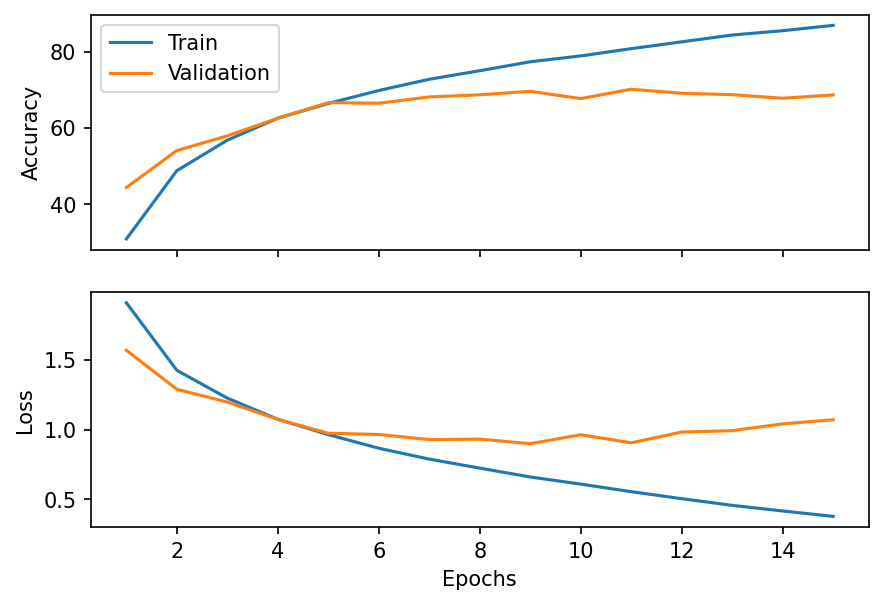

Précision en test: 68.88


In [8]:
weight_decay = 1e-3

torch.manual_seed(42)
net_l2 = CifarNet()
optimizer_l2 = optim.SGD(net_l2.parameters(), lr=lr, weight_decay=weight_decay)

history_l2 = train(net_l2, optimizer_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_l2.display()
print('Précision en test: {:.2f}'.format(test(net_l2, cifar_test, batch_size)))

#### Questions
- Quel est l'effet de la régularisation L2 sur l'entraînement du réseau? 

    **Au niveau de l'accuracy, on remarque que les performances en validation et en test sont légèrement meilleures. Également, l'utilisation de la régularisation réduit le surapprentissage. En effet l'écart des valeurs d'accuracy et de loss entre l'entraînement et la validation est nettement moins important (voir graphiques)**
    
- Si vous utilisez un `weight_decay` trop grand (exemple 0.1) qu'arrive-t-il? Pourquoi? 
    **Le réseau ne parvient tout simplement pas à apprendre, car la pénalité sur les poids est trop importante.**

Dans la cellule suivante, analysez avec un histogramme la distribution des poids appris par les réseaux avec ou sans régularisation. 

- Que remarquez-vous? 

    **Avec la régularisation L2, les poids appris sont plus concentrés près de 0.**
    
- Essayez d'autres valeurs de weight decay (1e-2, 1e-4) et observez l'impact sur la distribution des poids appris. 
    
    **Plus le weight decay est élevé (1e-2), plus la distribution des poids se resserre autour de zéro. À l'opposé, plus le weight decay est faible (1e-4), plus la distribution des poids régularisés ressemble à la distribution des poids appris sans régularisation**

Poids sans régularisation L2: variance 0.0056, maximum 1.7885.
Poids avec régularisation L2: variance 0.0032, maximum 1.3788.


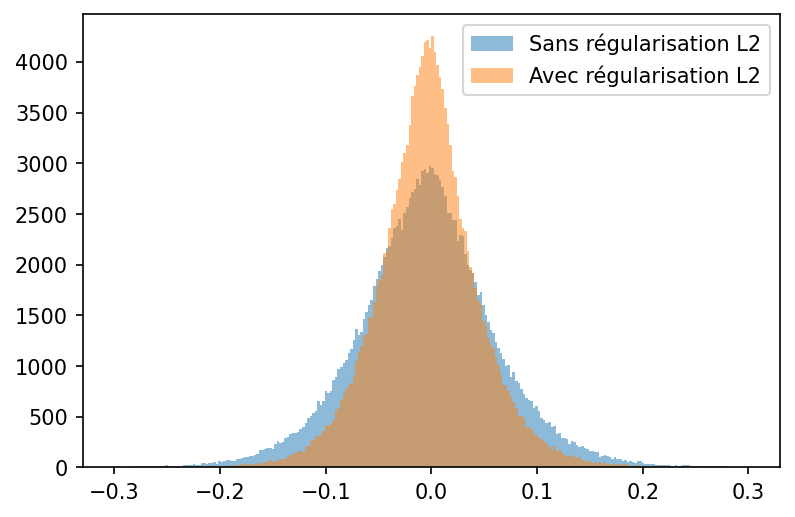

In [9]:
def net_to_weight_array(net):
    weights = []
    for p in net.parameters():
        p_numpy = p.data.cpu().numpy()
        weights.append(p_numpy.reshape((-1))) # Reshape to 1D array
    return np.concatenate(weights)

weights_without_l2 = net_to_weight_array(net_without_l2)
weights_l2 = net_to_weight_array(net_l2)

print("Poids sans régularisation L2: variance {:.4f}, maximum {:.4f}.".format(np.var(weights_without_l2), 
                                                                              np.max(np.abs(weights_without_l2))))
print("Poids avec régularisation L2: variance {:.4f}, maximum {:.4f}.".format(np.var(weights_l2), 
                                                                              np.max(np.abs(weights_l2))))

# Visualisation
plt.hist(weights_without_l2, bins=250, range=(-0.3, 0.3), alpha =0.5, label="Sans régularisation L2")
plt.hist(weights_l2, bins=250, range=(-0.3, 0.3), alpha=0.5, label="Avec régularisation L2")
plt.legend()
plt.show()

## Partie 2: Early stopping

Commencez par entraîner un réseau pour un grand nombre d'époques. L'historique d'entraînement nous servira de base pour les questions qui suivent.

In [10]:
torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-3, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=3, factor=0.5, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=40, batch_size=64, callbacks=[scheduler], use_gpu=True)

Epoch:  1/40 Step: 625/625 100.00% |████████████████████|9.20s loss: 1.586459 acc: 45.542500 val_loss: 1.348909 val_acc: 52.000000
Epoch:  2/40 Step: 625/625 100.00% |████████████████████|9.40s loss: 1.181110 acc: 58.050000 val_loss: 1.178002 val_acc: 58.430000
Epoch:  3/40 Step: 625/625 100.00% |████████████████████|9.09s loss: 1.000868 acc: 64.727500 val_loss: 1.385558 val_acc: 53.420000
Epoch:  4/40 Step: 625/625 100.00% |████████████████████|9.04s loss: 0.872313 acc: 69.727500 val_loss: 1.045378 val_acc: 63.260000
Epoch:  5/40 Step: 625/625 100.00% |████████████████████|8.93s loss: 0.783196 acc: 73.007500 val_loss: 0.998275 val_acc: 65.720000
Epoch:  6/40 Step: 625/625 100.00% |████████████████████|9.17s loss: 0.717265 acc: 75.357500 val_loss: 0.942488 val_acc: 67.230000
Epoch:  7/40 Step: 625/625 100.00% |████████████████████|9.25s loss: 0.653578 acc: 77.695000 val_loss: 1.014268 val_acc: 65.580000
Epoch:  8/40 Step: 625/625 100.00% |████████████████████|9.41s loss: 0.600576 acc: 

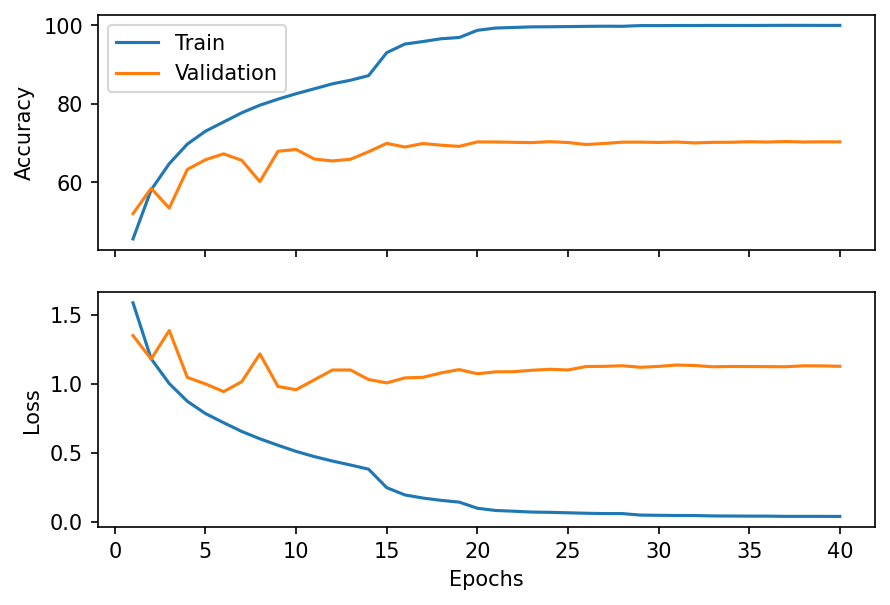

In [11]:
history.display()

#### Question
- En regardant les graphiques ci-dessus, quel est le meilleur moment pour arrêter l'entraînement? 

    **Autour de l'époque 20 la précision en validation semble la plus élevée et commence à être stable.**

L'algorithme 7.1 du livre (voir http://www.deeplearningbook.org/contents/regularization.html page 244) décrit le paramètre de patience `p` dans le contexte d'un algorithme de *early stopping* (**Attention**: le paramètre de patience `p` du *early stopping* n'a pas de lien avec le paramètre `p` correspondant à l'ordre d'une norme de la section précédente).

#### Exercice
- Analysez l'effet du choix de `p` sur les données de l'entraînement précédent. Regardez pour `p = 1,2,5,10,15`, quelle époque avec quelle précision en validation est choisie. Implémentez un algorithme effectuant du *early stopping* en utilisant l'historique `val_accuracy` de l'entraînement que vous venez d'exécuter pour vos tests (à la place d'entraîner le réseau).

In [12]:
# Historique
val_accuracy_history = history.history['val_acc']

# Patience
p = 5

best_val_accuracy = -np.inf
best_epoch = -1

# TODO
counter = 0
for epoch, val_accuracy in enumerate(val_accuracy_history):
    # Amélioration de la précision en validation
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        counter = 0
    # On patiente ...
    else:
        counter += 1
        if counter == p:
            break
# TODO END
            
print("Pour patience p={}, la meilleure époque est {}, avec précision en validation de {:.2f}.".format(p, best_epoch, best_val_accuracy))

Pour patience p=5, la meilleure époque est 23, avec précision en validation de 70.34.


#### Question

- Identifiez des problèmes pratiques potentiels lors de l'utilisation du *early stopping*. 

    **Il est difficile de sélectionner la bonne valeur de patience. Une valeur trop faible arrête l'entraînement trop tôt ce qui peut résulter en un modèle avec de moins bonnes performances, alors qu'une valeur trop élevée de patience peut nous obliger à calculer un nombre d'époques plus important que nécessaire (temps)**

### Pour aller plus loin sur le early stopping
Avec Poutyne, on peut effectuer le *early stopping* automatiquement grâce au callback [EarlyStopping](https://poutyne.org/callbacks.html#poutyne.EarlyStopping). Il faut spécifier la métrique à monitorer ainsi que la patience, et on peut également contrôler l'amplitude minimum d'un changement pour que celui-ci soit qualifié comme une amélioration avec le paramètre `min_delta`. L'entraînement va donc s'arrêter automatiquement lorsqu'il n'y a plus d'amélioration pour un nombre consécutif d'époques correspondant à la patience, prévenant possiblement le calcul inutile de plusieurs époques.

In [13]:
# Patience
p = 3

torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-3, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=3, factor=0.5, verbose=True)

# Early stopping sous la forme d'un Callback
early_stopping = pt.EarlyStopping(monitor='val_acc', mode='max', min_delta=1e-5, patience=p, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=40, batch_size=64, callbacks=[scheduler, early_stopping], use_gpu=True)

Epoch:  1/40 Step: 625/625 100.00% |████████████████████|11.23s loss: 1.585511 acc: 45.570000 val_loss: 1.304788 val_acc: 52.520000
Epoch:  2/40 Step: 625/625 100.00% |████████████████████|10.84s loss: 1.174797 acc: 58.292500 val_loss: 1.191580 val_acc: 58.170000
Epoch:  3/40 Step: 625/625 100.00% |████████████████████|10.65s loss: 0.992540 acc: 65.132500 val_loss: 1.095448 val_acc: 61.760000
Epoch:  4/40 Step: 625/625 100.00% |████████████████████|10.43s loss: 0.869717 acc: 69.967500 val_loss: 0.991179 val_acc: 65.680000
Epoch:  5/40 Step: 625/625 100.00% |████████████████████|10.56s loss: 0.781137 acc: 73.010000 val_loss: 1.055289 val_acc: 63.760000
Epoch:  6/40 Step: 625/625 100.00% |████████████████████|10.37s loss: 0.717907 acc: 75.290000 val_loss: 0.982759 val_acc: 66.230000
Epoch:  7/40 Step: 625/625 100.00% |████████████████████|10.62s loss: 0.653439 acc: 77.485000 val_loss: 0.980719 val_acc: 67.140000
Epoch:  8/40 Step: 625/625 100.00% |████████████████████|11.01s loss: 0.6014

## Partie 3: Dropout
Cette section a pour but d'analyser l'effet du dropout dans un réseau fully connected. Nous ferons cette analyse en reprenant l'exercice du laboratoire 2.

#### Exercice
- Dans le réseau suivant, implémentez la fonction `forward()` formée de couches linéaires suivies d'activation   `Relu` en ajoutant du dropout ([Indice](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.dropout)) après l'activation si `self.use_dropout == True` . Utilisez une probabilité de dropout de `0.3` indiqué par `self.dropout_p` et ne faites pas de dropout sur la couche de sortie. N'ajoutez **pas de softmax** car la fonction `deeplib.training.train()` utilise par défaut `CrossEntropyLoss`, ce qui le fait pour vous. 

> **ATTENTION!** Vous devez bien fixer l'argument `training` de dropout. Vous pouvez savoir si modèle est en entraînement ou en évaluation avec `self.training`.

In [14]:
class MnistModel(torch.nn.Module):
    
    def __init__(self, n_layers, hidden_size=100, use_dropout=True, dropout_p=0.3):
        super().__init__()
        torch.manual_seed(42)
        self.use_dropout = use_dropout
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        
        # Initialisation des couches
        layer_sizes = [28*28] + [self.hidden_size]*n_layers
        self.layers = nn.ModuleList()
        for input_size, output_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer = nn.Linear(input_size, output_size)
            layer.weight.data.normal_(0.0, math.sqrt(2 / input_size))
            layer.bias.data.fill_(0)
            self.layers.append(layer)
            
        
        # Couche de sortie avec une neurone par classe
        self.output_layer = nn.Linear(hidden_size,10)
        self.output_layer.weight.data.normal_(0.0, math.sqrt(2 / hidden_size))
        self.output_layer.bias.data.fill_(0)              

    def forward(self, x):
        out = x.view(-1, 28*28)
        for layer in self.layers:
            # TODO
            out = layer(out)
            out = torch.relu(out)
            if self.use_dropout:
                out = F.dropout(out, self.dropout_p, training=self.training)
            # TODO END
        return self.output_layer(out)

#### Question
- Quelle est l'importance de l'argument `training` de la fonction de dropout? 

    **Il permet d'appliquer le dropout seulement lorsqu'on entraine le réseau.**

Entraînez un réseau avec dropout et un réseau sans dropout.

In [15]:
# Paramètres
lr = 0.01
batch_size = 64
n_epoch = 20

Réseau sans dropout:

Epoch:  1/20 Step: 750/750 100.00% |████████████████████|8.79s loss: 0.373826 acc: 89.047917 val_loss: 0.218013 val_acc: 93.408333
Epoch:  2/20 Step: 750/750 100.00% |████████████████████|8.79s loss: 0.170625 acc: 94.983333 val_loss: 0.150999 val_acc: 95.383333
Epoch:  3/20 Step: 750/750 100.00% |████████████████████|9.33s loss: 0.124406 acc: 96.279167 val_loss: 0.127082 val_acc: 96.250000
Epoch:  4/20 Step: 750/750 100.00% |████████████████████|8.94s loss: 0.097777 acc: 97.072917 val_loss: 0.122904 val_acc: 96.275000
Epoch:  5/20 Step: 750/750 100.00% |████████████████████|8.71s loss: 0.080615 acc: 97.545833 val_loss: 0.111591 val_acc: 96.750000
Epoch:  6/20 Step: 750/750 100.00% |████████████████████|8.77s loss: 0.067297 acc: 97.943750 val_loss: 0.104903 val_acc: 96.816667
Epoch:  7/20 Step: 750/750 100.00% |████████████████████|8.95s loss: 0.057716 acc: 98.270833 val_loss: 0.096871 val_acc: 96.925000
Epoch:  8/20 Step: 750/750 100.00% |████████████████████|9.05s loss: 0.048601 acc: 

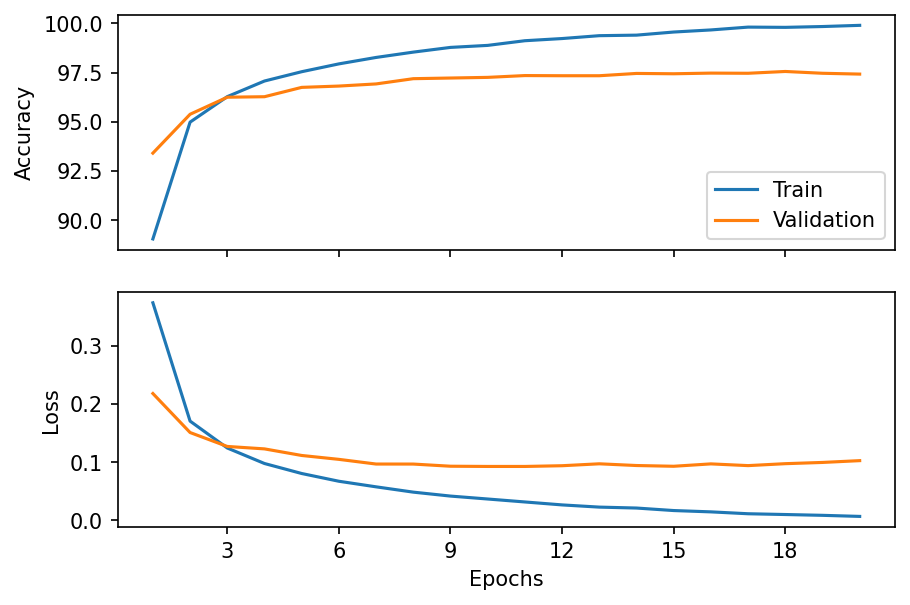

Précision en test: 97.67


In [16]:
net_without_dropout = MnistModel(2, use_dropout=False)
optimizer_without_dropout = optim.SGD(net_without_dropout.parameters(), lr, nesterov=True, momentum=0.9)

history_without_dropout = train(net_without_dropout, optimizer_without_dropout, mnist_train, n_epoch, batch_size, use_gpu=True)
history_without_dropout.display()
print('Précision en test: {:.2f}'.format(test(net_without_dropout, mnist_test, batch_size)))

Réseau avec dropout:

Epoch:  1/20 Step: 750/750 100.00% |████████████████████|9.32s loss: 0.579784 acc: 82.112500 val_loss: 0.228837 val_acc: 92.991667
Epoch:  2/20 Step: 750/750 100.00% |████████████████████|8.88s loss: 0.302608 acc: 91.070833 val_loss: 0.172203 val_acc: 94.775000
Epoch:  3/20 Step: 750/750 100.00% |████████████████████|8.79s loss: 0.244518 acc: 92.595833 val_loss: 0.153628 val_acc: 95.408333
Epoch:  4/20 Step: 750/750 100.00% |████████████████████|9.08s loss: 0.213453 acc: 93.747917 val_loss: 0.134625 val_acc: 95.933333
Epoch:  5/20 Step: 750/750 100.00% |████████████████████|9.26s loss: 0.190360 acc: 94.314583 val_loss: 0.122415 val_acc: 96.300000
Epoch:  6/20 Step: 750/750 100.00% |████████████████████|9.61s loss: 0.174393 acc: 94.818750 val_loss: 0.116013 val_acc: 96.550000
Epoch:  7/20 Step: 750/750 100.00% |████████████████████|9.42s loss: 0.164453 acc: 95.091667 val_loss: 0.114650 val_acc: 96.508333
Epoch:  8/20 Step: 750/750 100.00% |████████████████████|9.67s loss: 0.154530 acc: 

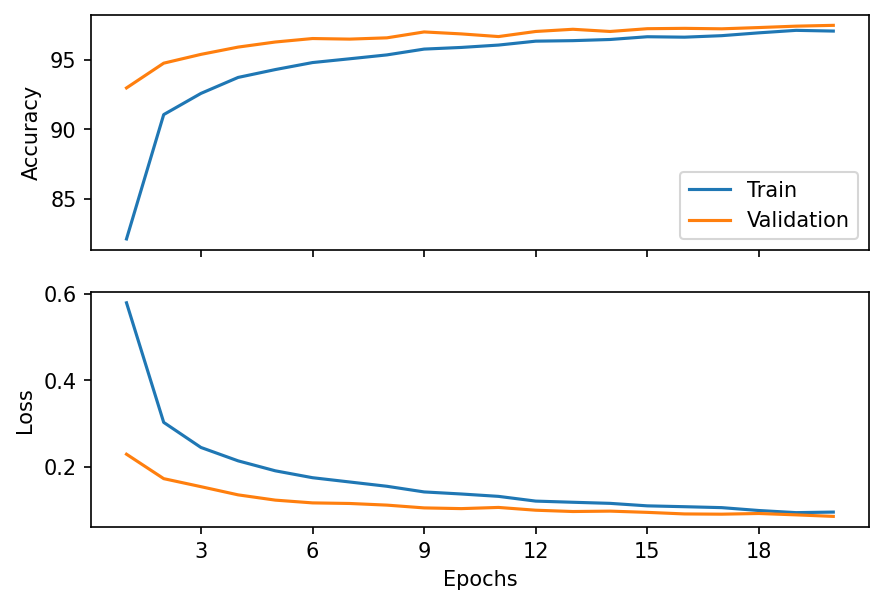

Précision en test: 97.62


In [17]:
net_with_dropout = MnistModel(2, use_dropout=True, dropout_p=0.3)
optimizer_with_dropout = optim.SGD(net_with_dropout.parameters(), lr, nesterov=True, momentum=0.9)

history_with_dropout = train(net_with_dropout, optimizer_with_dropout, mnist_train, n_epoch, batch_size, use_gpu=True)
history_with_dropout.display()
print('Précision en test: {:.2f}'.format(test(net_with_dropout, mnist_test, batch_size)))

#### Questions
- Quel est l'effet du dropout sur l'entraînement du réseau? 

    **Sans dropout, le réseau a des performances en entraînement qui s'éloignent des performances en validation plus on avance dans les époques, c'est-à-dire du surapprentissage. À l'opposé, avec le dropout le réseau à des performances en entraînement proches des performances en validation tout au long des époques, avec même des résultats légèrement meilleurs en validation dans notre cas. Il est important de noter que le dropout a une influence différente en mode entraînement et en mode évaluation, par conséquent les performances en entraînement pourraient être supérieures si on évalue le réseau en mode évaluation pour les données d'entraînement.**
    
- Essayez plusieurs valeurs de dropout et observez les effets.

    **Avec des valeurs de dropout trop faibles (0.01), il n'y a pas vraiment d'effets sur l'apprentissage du réseau. Avec des valeurs de dropout trop élevées (0.9), le réseau a de la difficulté à apprendre.**